<a href="https://colab.research.google.com/github/zwcrowley/module_21_deep_learning_challenge/blob/main/deep_learning_charity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 4: Predicting Congressional Bill Passage**

# Senate Model: Machine Learning Optimization and Model Output

## Team 7


## Import dependencies and read in data:

In [2]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from keras.models import load_model
from keras.utils import plot_model
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#  Import and read the cleaned house data from AWS S3:
# senate_df = pd.read_csv("https://raw.githubusercontent.com/JJERANEK/Project-4/main/Resources/senate_cleaned.csv")
# senate_df.head()

In [3]:
# Import from google drive folder:
# Mount google drive to get data:
from google.colab import drive
drive.mount('/content/gdrive')
senate_filepath = "/content/gdrive/MyDrive/DataClassNotebooks/Project-4/Resources/senate_cleaned.csv"
output_filepath = "/content/gdrive/MyDrive/DataClassNotebooks/Project-4/output"

# Read in senate data using pandas:
senate_df = pd.read_csv(senate_filepath)
# Glimpse senate data:
senate_df.head()

Mounted at /content/gdrive


,Bill Type,Congress,Number of Cosponsors,Cosponsor Dems,Cosponsor Reps,Cosponsor Ind,Cosponsor States,Committees,Latest Action,Subject,...,Housing and Community Development,Immigration,International Affairs,Labor and Employment,Native Americans,Public Lands and Natural Resources,"Science, Technology, Communications",Social Welfare,Transportation and Public Works,bill_passed
0,S.,116,0,0,0,0,0,Senate - Finance,Read twice and referred to the Committee on Fi...,Health,...,0,0,0,0,0,0,0,0,0,0
1,S.,116,0,0,0,0,0,Senate - Finance,Read twice and referred to the Committee on Fi...,Taxation,...,0,0,0,0,0,0,0,0,0,0
2,S.,116,22,22,0,0,16,Senate - Rules and Administration,Read twice and referred to the Committee on Ru...,"Elections, voting, political campaign regulation",...,0,0,0,0,0,0,0,0,0,0
3,S.,116,4,4,0,0,4,Senate - Finance,Read twice and referred to the Committee on Fi...,Health,...,0,0,0,0,0,0,0,0,0,0
4,S.,116,5,5,0,0,4,Senate - Homeland Security and Governmental Af...,Read twice and referred to the Committee on Ho...,Congressional oversight,...,0,0,0,0,0,0,0,0,0,0


# Senate Model

## Preprocessing:

In [4]:
# Check for NAs, duplicates and get the shape of the data:
print(f'The shape of the senate_df data is: {senate_df.shape}')
print(f'The number of NAs in the senate_df data: {senate_df.isnull().sum()}')
print(f'The duplicate rows of NAs in the senate_df data: {senate_df.duplicated().sum()}')
# There are 40 columns, 15593 rows, and no NAs or duplicates in the senate_df dataset.
# target is bill_passed

The shape of the senate_df data is: (21125, 69)
The number of NAs in the senate_df data: Bill Type                              0
Congress                               0
Number of Cosponsors                   0
Cosponsor Dems                         0
Cosponsor Reps                         0
                                      ..
Public Lands and Natural Resources     0
Science, Technology, Communications    0
Social Welfare                         0
Transportation and Public Works        0
bill_passed                            0
Length: 69, dtype: int64
The duplicate rows of NAs in the senate_df data: 425


In [5]:
# Numeric variable stats
senate_df.describe()

,Congress,Number of Cosponsors,Cosponsor Dems,Cosponsor Reps,Cosponsor Ind,Cosponsor States,Month Introduced,"Agriculture, Nutrition, and Forestry",Appropriations,Armed Services,...,Housing and Community Development,Immigration,International Affairs,Labor and Employment,Native Americans,Public Lands and Natural Resources,"Science, Technology, Communications",Social Welfare,Transportation and Public Works,bill_passed
count,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,...,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000,21125.000000
mean,115.298178,5.646201,3.366485,2.144757,0.134959,4.581491,5.709254,0.042556,0.009515,0.046154,...,0.008426,0.017562,0.025089,0.014533,0.009041,0.026888,0.017183,0.006627,0.023479,0.029065
std,1.390700,9.595980,6.763349,5.151765,0.388740,6.672063,3.187167,0.201859,0.097081,0.209823,...,0.091408,0.131356,0.156398,0.119675,0.094658,0.161759,0.129958,0.081139,0.151424,0.167993
min,113.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,114.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,116.000000,2.000000,1.000000,0.000000,0.000000,2.000000,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,117.000000,6.000000,3.000000,2.000000,0.000000,6.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,117.000000,99.000000,55.000000,53.000000,2.000000,50.000000,12.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Get the column names:
list(senate_df.columns)


['Bill Type',
 'Congress',
 'Number of Cosponsors',
 'Cosponsor Dems',
 'Cosponsor Reps',
 'Cosponsor Ind',
 'Cosponsor States',
 'Committees',
 'Latest Action',
 'Subject',
 'Sponsor Title',
 'Sponsor Party',
 'Sponsor State',
 'Month Introduced',
 'Agriculture, Nutrition, and Forestry',
 'Appropriations',
 'Armed Services',
 'Banking, Housing, and Urban Affairs',
 'Budget',
 'Commerce, Science, and Transportation',
 'Energy and Natural Resources',
 'Environment and Public Works',
 'Finance',
 'Foreign Relations',
 'Health, Education, Labor, and Pensions',
 'Homeland Security and Governmental Affairs',
 'Judiciary',
 'Rules and Administration',
 'Small Business and Entrepreneurship',
 'Veterans Affairs',
 'International Narcotics Control',
 'Ethics',
 'Indian Affairs',
 'Intelligence',
 'Printing',
 'Taxation',
 'Library',
 'Economic',
 'Academic performance and assessments',
 'Accounting and auditing',
 'Administrative law and regulatory procedures',
 'Administrative remedies',
 'Adv

In [7]:
# Check out Subject column:
print(f'Count of values for Subject column: \n{senate_df["Subject"].value_counts()}')

Count of values for Subject column: 
Health                                          1398
Armed Forces and National Security              1275
Administrative law and regulatory procedures     911
Taxation                                         849
Government Operations and Politics               695
                                                ... 
Congressional leadership                           1
National Council on Disability                     1
Nuclear Regulatory Commission (NRC)                1
Monetary policy                                    1
Venezuela                                          1
Name: Subject, Length: 707, dtype: int64


In [8]:
# Model Target:
senate_df["bill_passed"].value_counts()
# 614 bills  in the dataset which originated from the House became law in the 113th-117th Congresses

0    20511
1      614
Name: bill_passed, dtype: int64

In [9]:
# Drop the non-beneficial columns: 'Unnamed' column.
senate_df = senate_df.drop(["Bill Type","Subject", "Committees", "Latest Action" ], axis='columns')
senate_df.head()

,Congress,Number of Cosponsors,Cosponsor Dems,Cosponsor Reps,Cosponsor Ind,Cosponsor States,Sponsor Title,Sponsor Party,Sponsor State,Month Introduced,...,Housing and Community Development,Immigration,International Affairs,Labor and Employment,Native Americans,Public Lands and Natural Resources,"Science, Technology, Communications",Social Welfare,Transportation and Public Works,bill_passed
0,116,0,0,0,0,0,Sen.,D,MD,1,...,0,0,0,0,0,0,0,0,0,0
1,116,0,0,0,0,0,Sen.,D,CA,1,...,0,0,0,0,0,0,0,0,0,0
2,116,22,22,0,0,16,Sen.,D,OR,1,...,0,0,0,0,0,0,0,0,0,0
3,116,4,4,0,0,4,Sen.,D,MD,1,...,0,0,0,0,0,0,0,0,0,0
4,116,5,5,0,0,4,Sen.,D,NY,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
senate_df.dtypes
# Need to create dummies for: Subject, Sponsor Title,  Sponsor Party, Sponsor State columns
# Need to bin Subject column before creating dummy vars.

Congress                               int64
Number of Cosponsors                   int64
Cosponsor Dems                         int64
Cosponsor Reps                         int64
Cosponsor Ind                          int64
                                       ...  
Public Lands and Natural Resources     int64
Science, Technology, Communications    int64
Social Welfare                         int64
Transportation and Public Works        int64
bill_passed                            int64
Length: 65, dtype: object

In [13]:
# Determine the number of unique values in each column.
senate_df.nunique()

Congress                                5
Number of Cosponsors                   87
Cosponsor Dems                         53
Cosponsor Reps                         53
Cosponsor Ind                           3
                                       ..
Public Lands and Natural Resources      2
Science, Technology, Communications     2
Social Welfare                          2
Transportation and Public Works         2
bill_passed                             2
Length: 65, dtype: int64

In [ ]:
# Look at Subject value counts for binning
# Subject_counts_sen = senate_df["Subject"].value_counts()
# print(f'Count of values for Subject column: \n{Subject_counts_sen}')

In [ ]:
# Now change cutoff value to get  bins for Subject
# Cutoff value of 100 to bin: 
# use the variable name `Subject_types_to_replace_sen`
# Subject_types_to_replace_sen = list(Subject_counts_sen[Subject_counts_sen<100].index)

# # Replace in dataframe
# for sub in Subject_types_to_replace_sen:
#     senate_df['Subject'] = senate_df['Subject'].replace(sub,"Other")

# # Check to make sure binning was successful
# senate_df['Subject'].value_counts()
# 27 Bins

In [14]:
# Convert categorical data to numeric with `pd.get_dummies`
senate_df = pd.get_dummies(senate_df,dtype=float)
senate_df.head()
# Creates a df of 114 columns

,Congress,Number of Cosponsors,Cosponsor Dems,Cosponsor Reps,Cosponsor Ind,Cosponsor States,Month Introduced,"Agriculture, Nutrition, and Forestry",Appropriations,Armed Services,...,Sponsor State_SD,Sponsor State_TN,Sponsor State_TX,Sponsor State_UT,Sponsor State_VA,Sponsor State_VT,Sponsor State_WA,Sponsor State_WI,Sponsor State_WV,Sponsor State_WY
0,116,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,116,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,116,22,22,0,0,16,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,116,4,4,0,0,4,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,116,5,5,0,0,4,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Save clean/processed house data:
# senate_df.to_csv(f'{output_filepath}/senate_processed.csv' ,index=False)

In [18]:
# Split our preprocessed data into our features and target arrays
y = senate_df["bill_passed"].values
X = senate_df.drop(["bill_passed"], axis='columns').values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [19]:
# Create a StandardScaler instances
senate_scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = senate_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

### Attempt #1


*   Total layers: 5 total
*   Activation function to for each layer is: relu, relu, tanh, tanh,  sigmoid
*   Number of neurons for each hidden layers: 9,7,7,5,1
*   Epochs: 100

In [20]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  9
hidden_nodes_layer2_3 = 7
hidden_nodes_layer4 = 5

nn_sen = tf.keras.models.Sequential()

# First hidden layer
nn_sen.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_sen.add(tf.keras.layers.Dense(units=hidden_nodes_layer2_3, activation="relu"))

# Third hidden layer
nn_sen.add(tf.keras.layers.Dense(units=hidden_nodes_layer2_3, activation="tanh"))

# Fourth hidden layer
nn_sen.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="tanh"))

# Output layer
nn_sen.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_sen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 1044      
                                                                 
 dense_1 (Dense)             (None, 7)                 70        
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 5)                 40        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,216
Trainable params: 1,216
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile the model
nn_sen.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Train the model
fit_model = nn_sen.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
496/496 [==============================] - 2s 2ms/step - loss: 0.2286 - accuracy: 0.9300
Epoch 2/100
496/496 [==============================] - 1s 2ms/step - loss: 0.1301 - accuracy: 0.9705
Epoch 3/100
496/496 [==============================] - 1s 2ms/step - loss: 0.1265 - accuracy: 0.9705
Epoch 4/100
496/496 [==============================] - 1s 2ms/step - loss: 0.1215 - accuracy: 0.9705
Epoch 5/100
496/496 [==============================] - 1s 2ms/step - loss: 0.1167 - accuracy: 0.9704
Epoch 6/100
496/496 [==============================] - 1s 2ms/step - loss: 0.1135 - accuracy: 0.9702
Epoch 7/100
496/496 [==============================] - 1s 2ms/step - loss: 0.1104 - accuracy: 0.9705
Epoch 8/100
496/496 [==============================] - 1s 2ms/step - loss: 0.1073 - accuracy: 0.9701
Epoch 9/100
496/496 [==============================] - 1s 3ms/step - loss: 0.1047 - accuracy: 0.9706
Epoch 10/100
496/496 [==============================] - 1s 3ms/step - loss: 0.1027 - accura

In [23]:
# Evaluate the Senate model using the test data:
model_loss_1, model_accuracy_1 = nn_sen.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {round(model_loss_1,4)}, Accuracy: {round(model_accuracy_1,4)}")

166/166 - 0s - loss: 0.1548 - accuracy: 0.9576 - 396ms/epoch - 2ms/step
Loss: 0.1548, Accuracy: 0.9576


### Senate model had an accuracy of 95.76%

In [24]:
# Export the model and scaler from senate data to HDF5 file
from google.colab import files

output_filepath = "/content/gdrive/MyDrive/DataClassNotebooks/Project-4/output"

# Save model 2, nn_2, and download a copy to local machine:
nn_sen.save(f'{output_filepath}/senate_model.h5')
files.download(f'{output_filepath}/senate_model.h5')

# Save the StandardScaler() instance, senate_scaler, for use in the flask app later:
dump(senate_scaler, f'{output_filepath}/senate_scaler.bin', compress=True)
files.download(f'{output_filepath}/senate_scaler.bin')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize the Senate model:

In [ ]:
# Set up output file:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files
output_filepath = "/content/gdrive/MyDrive/DataClassNotebooks/Project-4/output"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


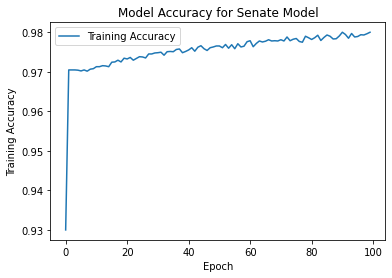

In [25]:
# Plot the accuracy of the training and testing for the senate_model:
plt.plot(fit_model.history['accuracy'])
# plt.plot(fit_model.history['loss'])
plt.title('Model Accuracy for Senate Model')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.legend(["Training Accuracy"], loc='upper left')
plt.savefig(f'{output_filepath}/senate_model_accuracy.png', bbox_inches='tight')
plt.show()


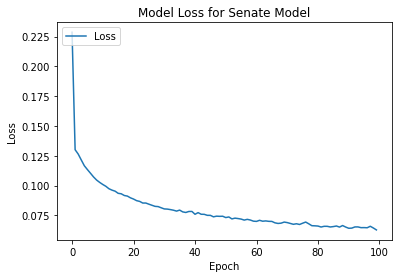

In [26]:
# Plot the accuracy of the training and testing for the senate_model:
plt.plot(fit_model.history['loss'])
plt.title('Model Loss for Senate Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.savefig(f'{output_filepath}/senate_model_loss.png', bbox_inches='tight')
plt.show()

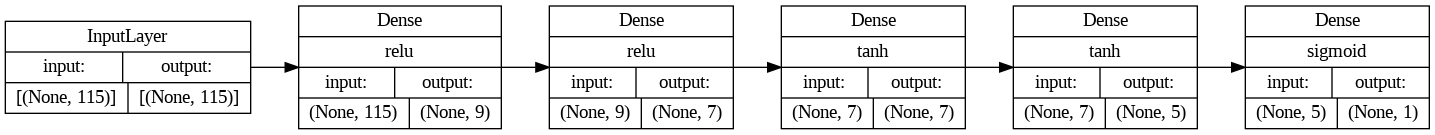

In [27]:
# Load in saved senate_model.h5:
senate_model = load_model(f'{output_filepath}/senate_model.h5')
# Create a visual of the nn model built using the senate data:
# Filepath to save image of model visual to:
senate_pic_file = f'{output_filepath}/senate_model_nn.png'
# LR is horizontal and TB is vertical
tf.keras.utils.plot_model(
    senate_model,
    to_file = senate_pic_file,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="LR",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)